# TO-DO

- Add measurement noise

In [1]:
import sys
import numpy as np
sys.path.append("/SNS/users/m2d/git/machine_learning/src")
import importlib
import models
import os
import matplotlib
import matplotlib.pyplot as plt

2023-06-05 20:31:57.419535: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [39]:
data_dir = os.path.expanduser("~m2d/git/analysis_playground/ml/data/training_data")

pars = np.load(os.path.join(data_dir, "orhs3_pars.npy"))[:1000000]
refl = np.load(os.path.join(data_dir, "orhs3_data.npy"))[:1000000]
q_values = np.load(os.path.join(data_dir, "orhs3_q_values.npy"))

print(pars.shape)
print(refl.shape)
print(q_values.shape)

#refl = np.power(10, refl)/q_values**2*q_values[0]**2

idx = 0
nset=10000
refl= np.asarray(refl[:-nset])
pars= np.asarray (pars[:-nset])

testset= np.asarray(refl[-nset:])
testsetout= np.asarray(pars[-nset:])
testpars = np.asarray (pars[-nset:])

(999999,)
(999999, 100)
(100,)


In [3]:
import importlib
importlib.reload(models)
n_data = refl.shape[0]
n_features = refl.shape[1]
n_outputs = 20

ae_model, encoder, decoder =models.auto_encoder(n_data, n_features, n_outputs)
history = ae_model.fit(refl, refl,
                        epochs=20, batch_size=256,
                        validation_data=(testset, testset))


Auto-encoder ready
Epoch 1/20
3868/3868 [==============================] - 35s 9ms/step - loss: 0.0465 - val_loss: 0.0088
Epoch 2/20
3868/3868 [==============================] - 33s 9ms/step - loss: 0.0054 - val_loss: 0.0036
Epoch 3/20
3868/3868 [==============================] - 33s 9ms/step - loss: 0.0036 - val_loss: 0.0024
Epoch 4/20
3868/3868 [==============================] - 33s 9ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 5/20
3868/3868 [==============================] - 33s 9ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 6/20
3868/3868 [==============================] - 33s 9ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 7/20
3868/3868 [==============================] - 33s 9ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 8/20
3868/3868 [==============================] - 33s 9ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 9/20
3868/3868 [==============================] - 33s 9ms/step - loss: 0.0014 - val_loss: 9.6731e-04
Epoch 10/20
3868/3868 [===========================

In [4]:
models.save_model(ae_model, encoder, decoder, "/SNS/users/m2d/git/machine_learning/data")

In [5]:
y_pred = ae_model.predict(testset)
latent_space = encoder.predict(testset)
print(y_pred.shape)
print(latent_space.shape)
idx=0

313/313 [==============================] - 1s 2ms/step
(10000, 100)
(10000, 20)


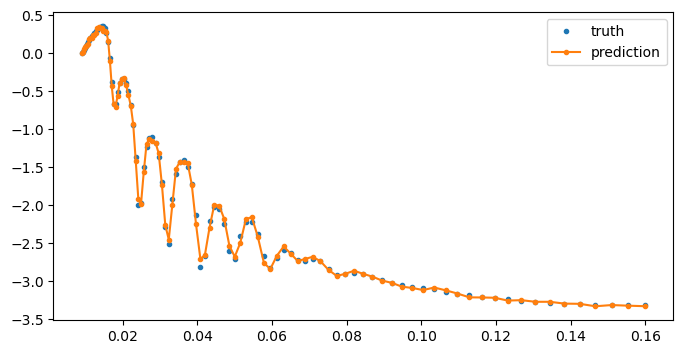

In [17]:
fig=plt.figure(dpi=100, figsize=[8,4])
plt.plot(q_values, testset[idx], marker='.', linestyle='', label='truth')
plt.plot(q_values, y_pred[idx], marker='.', linestyle='-', label='prediction')

plt.legend()
plt.show()

idx=idx+1

In [6]:
from sklearn.manifold import TSNE
tsne1 = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(latent_space).T


(2, 10000)


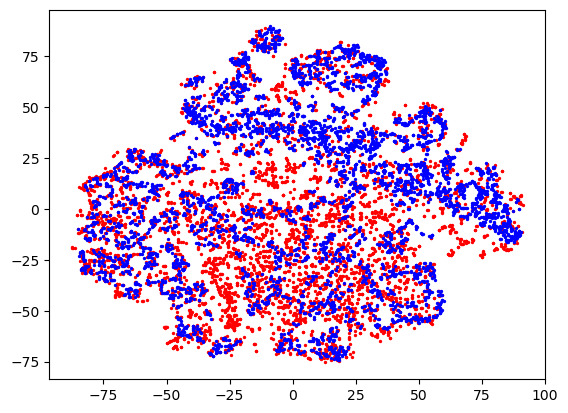

In [7]:
print(tsne1.shape)
fig = plt.figure()
class1 = testpars==0
class2 = testpars==1
plt.scatter(tsne1[0][class1], tsne1[1][class1], c='red', s=2)
plt.scatter(tsne1[0][class2], tsne1[1][class2], c='blue', s=2)
plt.show()

In [22]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(latent_space, testpars)



In [23]:
pred_class = neigh.predict(latent_space)
prob_class = neigh.predict_proba(latent_space)

In [55]:
count = 0
class_counts = []
for i in range(4):
    _counts = []
    for j in range(4):
        _c = np.sum([int(testpars[idx]==i and pred_class[idx]==j) for idx in range(len(testpars))])
        _counts.append(_c)
    print(_counts)

for idx in range(len(pred_class)):
    if testpars[idx]==pred_class[idx]:
        count += 1
                 
    if testpars[idx]==0 and pred_class[idx]==1:
        count_1_when_0 += 1
                 
    if testpars[idx]==1 and pred_class[idx]==0:
        count_0_when_1 += 1
                 
                 
    #status = '' if testpars[idx]==pred_class[idx] else 'FAIL'
    #print(testpars[idx], pred_class[idx], prob_class[idx], status)



print("Accuracy: %g" % (count/len(pred_class)))



[0, 0, 0, 0]
[0, 3287, 77, 1]
[0, 764, 2282, 215]
[0, 295, 639, 2440]
Accuracy: 0.8009


In [52]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(refl, pars)

pred_class = neigh.predict(testset)
prob_class = neigh.predict_proba(testset)
